In [1]:
import ExTRA as ex
from astropy.io import fits
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize


ExTRA  imported correctly


In [2]:
GAIA_EPOCH=Time('2017.5', format='jyear',scale="tcb")
GAIA_EPOCH_JY=GAIA_EPOCH.jyear
GAIA_EPOCH_JD=GAIA_EPOCH.jd

m1_MS = 0.76  # Primary star mass from paper Table 3
bh3_ra_deg = 294.8278502411 # Right Ascension from paper Table 2
bh3_dec_deg = 14.9309190720 # Declination from paper Table 2

lin.ra                         1.50624  ±  0.00708     
lin.dec                       -0.03341  ±  0.00674     
lin.parallax                   0.71520  ±  0.00871     
lin.mura                     -30.29679  ±  0.00477     
lin.mudec                   -148.62246  ±  0.00427 

In [3]:
#Gaia Single Star Solution
g_asc=bh3_ra_deg
g_dec=bh3_dec_deg
g_par=1.68 #mas
g_mua=-30.29679
g_mud=-148.62246
g_stand=np.array([g_asc,g_dec,g_par,g_mua,g_mud])

In [4]:
#read
rvdata=fits.open("data/GaiaBH3/bh3rv.fit")[1].data
astrodata=fits.open("data/GaiaBH3/bh3ast.fit")[1].data
#header
rv_names=rvdata.names[1:]
ast_names=astrodata.names

In [5]:
ast=[]
for name in ast_names:
    ast.append(astrodata.field(name))
ast=np.array(ast)
msk=ast[-1]==0
ast=np.array([row[msk] for row in ast])



rv=[]
for name in rv_names:
    rv.append(rvdata.field(name))
rv=np.array(rv)

# Pre RV fit

In [6]:
def RV_fit(theta,data):

    v0,K,P,e,om,T0=theta

    t,d,err=data

    L=ex.L_RVs(t,d,err,0,v0,K,P,e,om,T0)
    return L

In [7]:
x0_rv=(-360,50,3850,0.5,0,GAIA_EPOCH_JD)
bnds_rv=(-500,500),(50,200),(3000,5000),(0,0.8),(-np.pi,np.pi),(GAIA_EPOCH_JD-10000,GAIA_EPOCH_JD+10000)

In [8]:
rvfit=minimize(RV_fit,x0_rv,args=(rv),bounds=bnds_rv,options={"maxiter":1e10},tol=1e-15)
print("v0,K,P,e,om,T0 : \n",rvfit.x)
print(rvfit.fun)

v0,K,P,e,om,T0 : 
 [-3.59261394e+02  5.75987122e+01  4.89401896e+03  7.68455814e-01
  1.30067567e+00  2.45815153e+06]
29.256838442968345


In [9]:
t_rvmod=np.linspace(rv[0][0],rv[0][-1],1000)
rv_check=ex.RV_mod(*rvfit.x,t_rvmod)

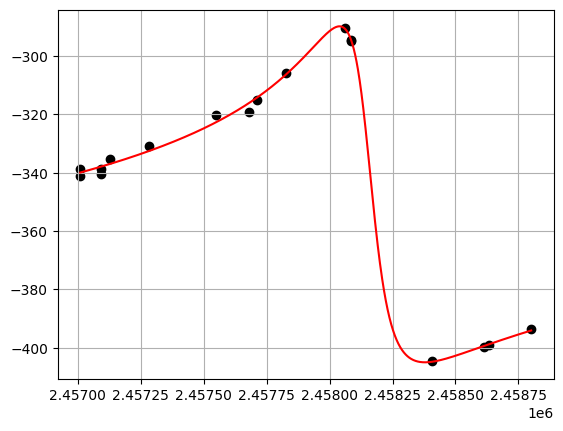

In [10]:
plt.plot(t_rvmod,rv_check,c="r")
plt.scatter(rv[0],rv[1],c="k")
plt.grid()
plt.show()

# Astrometric fit

In [11]:
relative_time=Time(ast[0], format='jd', scale='tcb').jyear-GAIA_EPOCH.jyear
gaia_angle=ex.angle_trafo(np.radians(ast[4]))





t_gaia=ast[0]
A2=relative_time
A3=np.cos(gaia_angle)
A4=np.sin(gaia_angle)
A5=ast[3]
A6=A3*A2
A7=A4*A2
A8=ast[1]
A9=ast[2]
gaia=np.array([A3,A4,A5,A6,A7,A8,A9])


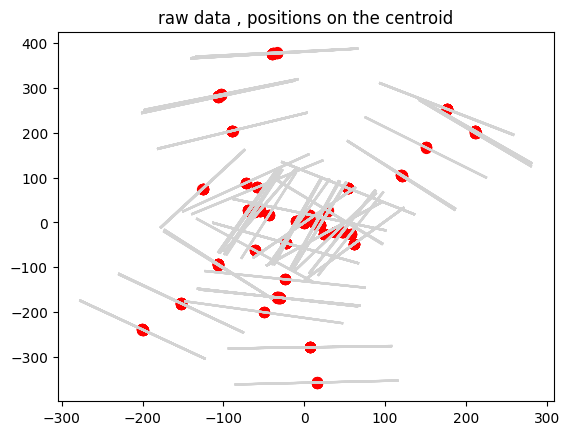

In [12]:
raw_2d=ex.hip_2d(gaia)
err_2d=np.array([raw_2d[1],raw_2d[3]])
ex.plot_hip(*raw_2d,size=100,s=50)
plt.title("raw data , positions on the centroid")
#plt.grid()
plt.show()

In [13]:
g_sss=ex.standard_model(*g_stand,t_gaia,ex.earth_position(t_gaia),tangential=True,Sepoch=GAIA_EPOCH_JD)

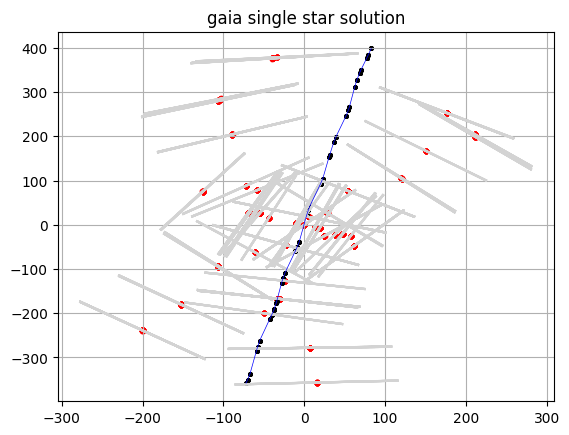

In [14]:
ex.plot_hip(*raw_2d,size=100,s=10)
plt.scatter(*g_sss,s=5,c="k")
plt.plot(*g_sss,c="b",linewidth=0.5)
#plt.axis("equal")
plt.title("gaia single star solution")
plt.grid()
plt.show()

In [15]:
planet_residual=ex.abs_res(gaia[-2],g_stand,np.array([g_asc,g_dec,0,0,0]),gaia)


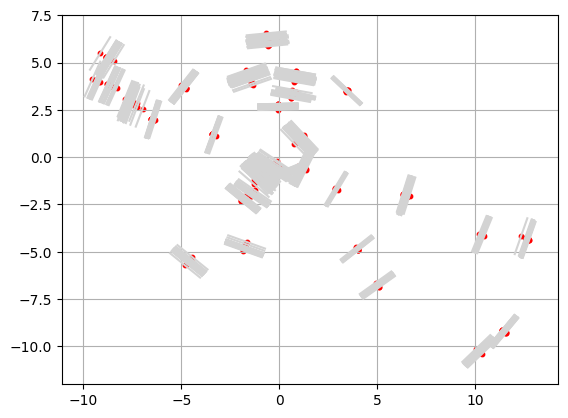

In [16]:
res_astrometric=np.copy(gaia)
res_astrometric[-2]=planet_residual

testing=ex.hip_2d(res_astrometric)


ex.plot_hip(*testing)

plt.grid()

In [17]:
#function you want to miniize
def gaia_min(theta,gaia_ad,gaia_s):

    P,e,om,i,Om,T0,a,del_asc,del_dec,del_para,del_mua,del_mud=theta
    #print(theta)

    correction=del_asc,del_dec,del_para,del_mua,del_mud

    L=ex.L_gaia(gaia_ad,gaia_s,correction,P,e,om,i,Om,T0,a)


    return L

4235.8 day
Eccentricity = 0.728
omega = 77.9 deg
Inclination  110.6 deg
OMEGA = 136.2 deg
T_periastron = 53941.2 day

In [18]:
P_g=4235.8
e_g=0.728
om_g=np.radians(77.9)
i_g=np.radians(110.6)
Om_g=np.radians(136.2)
T0_g=GAIA_EPOCH_JD
a_g=27.303
#guess
orb=np.array([P_g,e_g,om_g,i_g,Om_g,T0_g,a_g])
stand_corr=np.array([-6,3,0,0,0])
x0=np.concatenate([orb,stand_corr])

In [19]:
#bounds
orbbnds=(P_g-100,P_g+100),(0,0.95),(-np.pi,np.pi),(0,2*np.pi),(-np.pi,np.pi),(T0_g-10000,T0_g+10000),(0,100)
standbnds=(-10,10),(-10,10),(-10,10),(-10,10),(-10,10)
bnds=orbbnds+standbnds

In [20]:
fit=minimize(gaia_min,x0,args=(res_astrometric,g_stand),bounds=bnds,tol=1e-10,method="Nelder-mead",options={"maxiter":1e5})
print(fit)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -390.8744421622821
             x: [ 4.155e+03  7.243e-01  1.358e+00  1.931e+00  2.376e+00
                  2.458e+06  2.690e+01  4.289e+00  2.371e+00  8.965e-04
                  1.916e+00 -6.487e+00]
           nit: 17604
          nfev: 23916
 final_simplex: (array([[ 4.155e+03,  7.243e-01, ...,  1.916e+00,
                        -6.487e+00],
                       [ 4.155e+03,  7.243e-01, ...,  1.916e+00,
                        -6.487e+00],
                       ...,
                       [ 4.155e+03,  7.243e-01, ...,  1.916e+00,
                        -6.487e+00],
                       [ 4.155e+03,  7.243e-01, ...,  1.916e+00,
                        -6.487e+00]], shape=(13, 12)), array([-3.909e+02, -3.909e+02, ..., -3.909e+02, -3.909e+02],
                      shape=(13,)))


In [21]:
print("om,i,Om:",np.degrees(fit.x[2:5])) 

#om,i,Om: [-102.14730943  110.5892113   -43.78353324]

om,i,Om: [ 77.82790351 110.63168272 136.12540993]


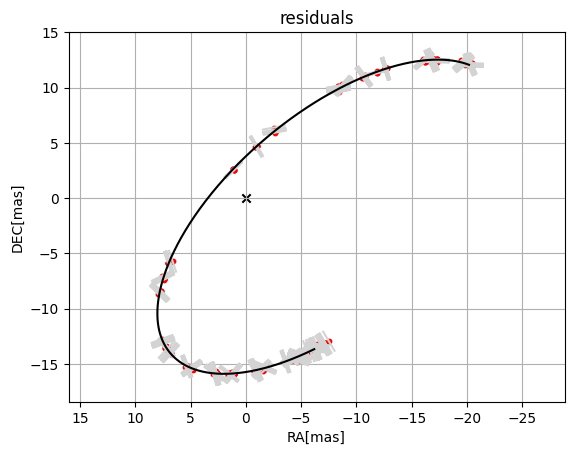

In [22]:
fit_residuals=ex.abs_res(planet_residual,fit.x[-5:],np.zeros(5),gaia[:5])

x_O,y_O=ex.orbit(*fit.x[:7],t_gaia)
    
res_gaia_final=fit_residuals-(A3*x_O+A4*y_O)

check=ex.res_to_orbit_gaia(res_gaia_final,gaia, fit.x[:7])


#ex.plot_hip(*ex.hip_2d(checking))

plt.title("residuals")
plt.ylabel("DEC[mas]")
plt.xlabel("RA[mas]")
plt.scatter(0,0,c="k",marker="x")

ex.plot_hip(*check)
plt.plot(*ex.orbit(*fit.x[:7],t_rvmod),c="k")



plt.gca().invert_xaxis()
plt.axis("equal")
plt.grid()

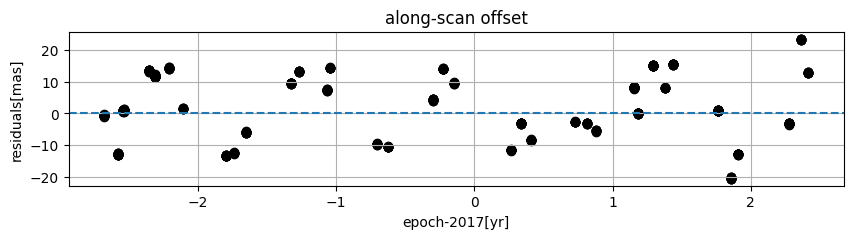

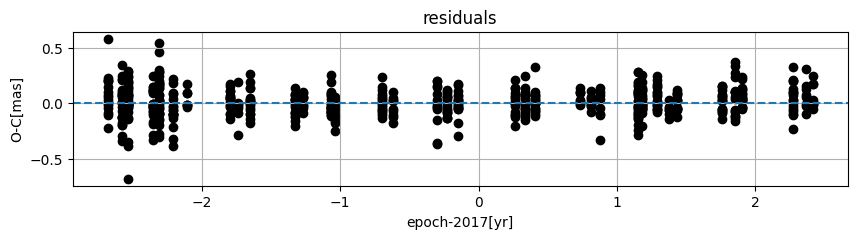

In [23]:
plt.figure(figsize=(10,2))
plt.scatter(relative_time,fit_residuals,c="k")
plt.axhline(0,linestyle="--")
plt.title("along-scan offset")
plt.ylabel("residuals[mas]")
plt.xlabel("epoch-2017[yr]")

plt.grid()
plt.show()

plt.figure(figsize=(10,2))
plt.scatter(relative_time,res_gaia_final,c="k")
plt.axhline(0,linestyle="--")
plt.title("residuals")
plt.ylabel("O-C[mas]")
plt.xlabel("epoch-2017[yr]")

plt.grid()
plt.show()



In [ ]:
def L_gaia_rv(theta,rvs,gaia_ad,gaia_stand):
    P,e,om,i,Om,T0,a=theta[:7]
    correction=theta[7:12]
    v0=theta[-1]

    t,data,err=rvs




    c_parallax=gaia_stand[2]+correction[2]

    

    Lg=ex.L_gaia(gaia_ad, gaia_stand, correction, P, e, om, i, Om, T0, a)

    Lr=ex.L_RVs_comb(t, data, err, 0,v0, P, e, om, i, T0, a, c_parallax)
    
    

    return Lg+Lr

In [ ]:
#units

rvmod=np.copy(rv)
rvmod[1:]=rvmod[1:]*1000

v0_g=np.array([-359.26*1000])
testtheta=np.concatenate((fit.x,v0_g))

In [32]:
#bounds
orbbnds=(P_g-100,P_g+100),(0,0.95),(-np.pi,np.pi),(0,2*np.pi),(-np.pi,np.pi),(T0_g-10000,T0_g+10000),(0,100)
standbnds=(-10,10),(-10,10),(-10,10),(-10,10),(-10,10)
v0_bnds=(v0_g-1e5,v0_g+1e5),
bnds=orbbnds+standbnds+v0_bnds

In [34]:
fitlol=minimize(L_gaia_rv,testtheta,args=(rvmod,res_astrometric,g_stand),bounds=bnds,tol=1e-10,method="Nelder-mead",options={"maxiter":1e5})
print(fitlol)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -243.36518436534377
             x: [ 4.211e+03  7.270e-01 ... -6.549e+00 -3.572e+05]
           nit: 6755
          nfev: 9424
 final_simplex: (array([[ 4.211e+03,  7.270e-01, ..., -6.549e+00,
                        -3.572e+05],
                       [ 4.211e+03,  7.270e-01, ..., -6.549e+00,
                        -3.572e+05],
                       ...,
                       [ 4.211e+03,  7.270e-01, ..., -6.549e+00,
                        -3.572e+05],
                       [ 4.211e+03,  7.270e-01, ..., -6.549e+00,
                        -3.572e+05]], shape=(14, 13)), array([-2.434e+02, -2.434e+02, ..., -2.434e+02, -2.434e+02],
                      shape=(14,)))


In [35]:
fitlol.x

array([ 4.21061539e+03,  7.27011179e-01,  1.35812232e+00,  1.93058047e+00,
        2.37697897e+00,  2.45817735e+06,  2.71713814e+01,  4.27971909e+00,
        2.40163736e+00,  3.57141937e-03,  1.94782559e+00, -6.54858181e+00,
       -3.57210590e+05])

In [43]:
rvcombined=ex.RV_comb(fitlol.x[-1],*fitlol.x[:4],*fitlol.x[5:7],g_stand[2],t_rvmod)

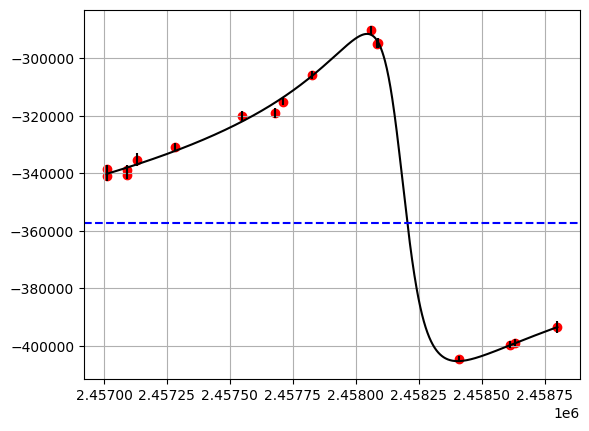

In [64]:
plt.plot(t_rvmod,rvcombined,c="k")
plt.scatter(rv[0],rv[1]*1000,c="r")
plt.errorbar(rv[0],rv[1]*1000,rv[2]*1000,linestyle="",c="k")
plt.axhline(fitlol.x[-1],c="b",linestyle="--")
plt.grid()
plt.show()

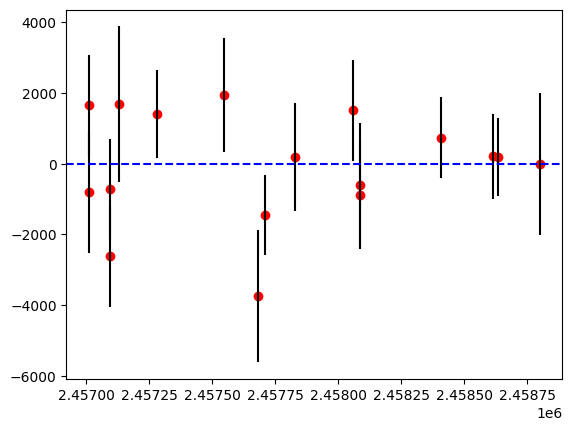

In [74]:
rv_res=rvmod[1]-ex.RV_comb(fitlol.x[-1],*fitlol.x[:4],*fitlol.x[5:7],g_stand[2],rv[0])

plt.scatter(rv[0],rv_res,c="r")
plt.errorbar(rv[0],rv_res,rv[2]*1000,c="k",linestyle="")
plt.axhline(0,c="b",linestyle="--")
plt.show()

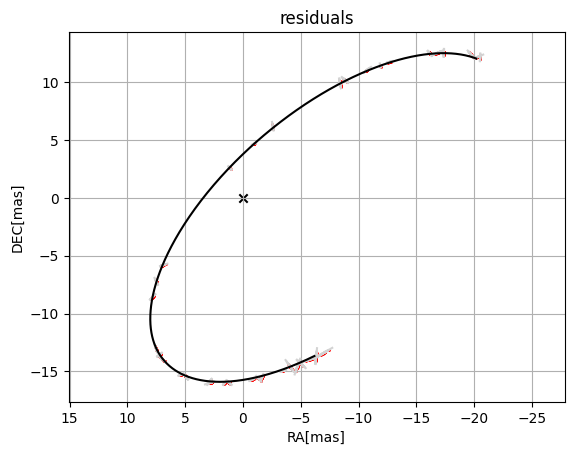

In [67]:
fit_residuals=ex.abs_res(planet_residual,fitlol.x[-6:-1],np.zeros(5),gaia[:5])

x_O,y_O=ex.orbit(*fitlol.x[:7],t_gaia)
    
res_gaia_final=fit_residuals-(A3*x_O+A4*y_O)

check=ex.res_to_orbit_gaia(res_gaia_final,gaia, fitlol.x[:7])


#ex.plot_hip(*ex.hip_2d(checking))

plt.title("residuals")
plt.ylabel("DEC[mas]")
plt.xlabel("RA[mas]")
plt.scatter(0,0,c="k",marker="x")

ex.plot_hip_err(*check)
plt.plot(*ex.orbit(*fit.x[:7],t_rvmod),c="k")



plt.gca().invert_xaxis()
plt.axis("equal")
plt.grid()

In [76]:
ex.K()

TypeError: K() missing 5 required positional arguments: 'P', 'e', 'i', 'a', and 'parallax'